In [1]:
import pandas as pd
import numpy as np
import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import importlib
import seaborn as sns
from scipy.stats import norm
from scipy import stats
pd.set_option('display.float_format', lambda x: '%.1f' % x)
pd.set_option('display.max_columns', 500)
import matplotlib.pyplot as plt


In [49]:
data = pd.read_csv('../../DMT_data/training_set_VU_DM.csv', error_bad_lines=False, sep=',', encoding='latin-1')

In [3]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

In [4]:
data.head(3)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,nan,nan,219,893,3,3.5,1,2.8,0.0,5.0,27,104.8,0,23246,1,0,4,0,1,1,nan,nan,1,nan,nan,nan,0.0,0.0,nan,0.0,0.0,nan,nan,nan,nan,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,nan,0,nan,0
1,1,2013-04-04 08:32:15,12,187,nan,nan,219,10404,4,4.0,1,2.2,0.0,5.0,26,170.7,0,23246,1,0,4,0,1,1,nan,nan,1,nan,nan,nan,nan,nan,nan,0.0,0.0,nan,nan,nan,nan,0.0,1.0,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,nan,0,nan,0
2,1,2013-04-04 08:32:15,12,187,nan,nan,219,21315,3,4.5,1,2.2,0.0,4.9,21,179.8,0,23246,1,0,4,0,1,1,nan,nan,1,nan,nan,nan,0.0,0.0,nan,0.0,0.0,nan,nan,nan,nan,0.0,0.0,nan,nan,nan,nan,nan,nan,nan,0.0,0.0,nan,0,nan,0


In [5]:
data.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate'

In [6]:
data.describe(include='all')

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
count,4958347.0,4958347,4958347.0,4958347.0,251866.0,252988.0,4958347.0,4958347.0,4958347.0,4950983.0,4958347.0,4958347.0,3867999.0,4958347.0,4958347.0,4958347.0,4958347.0,4958347.0,4958347.0,4958347.0,4958347.0,4958347.0,4958347.0,4958347.0,317406.0,3350565.0,4958347.0,119930.0,129559.0,94439.0,2024672.0,2130269.0,556238.0,1534288.0,1650990.0,472797.0,307378.0,343663.0,131086.0,2222373.0,2360020.0,841099.0,240157.0,260976.0,96174.0,315348.0,356422.0,138515.0,1916654.0,1987503.0,614730.0,4958347.0,138390.0,4958347.0
unique,nan,198615,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
top,nan,2012-11-02 14:04:51,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
freq,nan,95,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
mean,166366.6,NaN,10.0,175.3,3.4,176.0,174.0,70079.2,3.2,3.8,0.6,2.9,0.1,4.3,16.9,254.2,0.2,14042.6,2.4,37.5,2.0,0.4,1.1,0.5,-24.1,1301.2,0.3,0.5,0.0,244.2,0.0,0.0,18.5,0.0,0.1,27.1,-0.0,0.1,175.3,0.0,0.1,29.9,0.1,0.1,17.3,0.1,0.1,19.4,-0.1,0.0,22.4,0.0,386.3,0.0
std,96112.2,NaN,7.6,65.9,0.7,107.3,68.3,40609.9,1.1,1.1,0.5,1.5,0.2,1.8,10.4,16001.2,0.4,8111.8,2.1,52.0,0.9,0.7,0.4,0.5,15.7,2024.0,0.5,0.6,0.2,1165.4,0.4,0.2,240.1,0.5,0.3,1012.9,0.6,0.3,5757.7,0.5,0.3,1340.3,0.6,0.3,31.2,0.6,0.3,54.4,0.5,0.2,896.0,0.2,821.2,0.2
min,1.0,NaN,1.0,1.0,1.4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,-326.6,0.0,0.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,-1.0,-1.0,2.0,0.0,0.0,0.0
25%,82936.0,NaN,5.0,100.0,2.9,109.8,100.0,35010.0,3.0,3.5,0.0,1.8,0.0,4.5,8.0,85.0,0.0,7101.0,1.0,4.0,2.0,0.0,1.0,0.0,-30.8,139.8,0.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,6.0,0.0,0.0,7.0,0.0,0.0,7.0,0.0,124.0,0.0
50%,166507.0,NaN,5.0,219.0,3.5,152.2,219.0,69638.0,3.0,4.0,1.0,2.8,0.1,4.9,16.0,122.0,0.0,13541.0,2.0,17.0,2.0,0.0,1.0,1.0,-20.5,386.6,0.0,1.0,0.0,10.0,0.0,0.0,11.0,0.0,0.0,11.0,0.0,0.0,11.0,0.0,0.0,12.0,0.0,0.0,11.0,0.0,0.0,12.0,0.0,0.0,11.0,0.0,218.4,0.0
75%,249724.0,NaN,14.0,219.0,3.9,213.5,219.0,105168.0,4.0,4.5,1.0,4.0,0.2,5.3,26.0,185.0,0.0,21084.0,3.0,48.0,2.0,0.0,1.0,1.0,-13.4,1500.7,1.0,1.0,0.0,16.0,0.0,0.0,20.0,0.0,0.0,18.0,0.0,0.0,19.0,0.0,0.0,21.0,0.0,0.0,18.0,1.0,0.0,20.0,0.0,0.0,17.0,0.0,429.8,0.0


### Missing data

In [7]:
missing_data_table = draw_missing_data_table(data)

In [8]:
missing_data_table.T

,comp1_rate_percent_diff,comp6_rate_percent_diff,comp1_rate,comp1_inv,comp4_rate_percent_diff,gross_bookings_usd,comp7_rate_percent_diff,comp6_rate,visitor_hist_starrating,visitor_hist_adr_usd,comp6_inv,comp4_rate,comp7_rate,srch_query_affinity_score,comp4_inv,comp7_inv,comp3_rate_percent_diff,comp2_rate_percent_diff,comp8_rate_percent_diff,comp5_rate_percent_diff,comp3_rate,comp3_inv,comp8_rate,comp8_inv,comp2_rate,comp2_inv,comp5_rate,comp5_inv,orig_destination_distance,prop_location_score2,prop_review_score,prop_id,prop_starrating,prop_brand_bool,booking_bool,prop_country_id,visitor_location_country_id,site_id,date_time,prop_location_score1,random_bool,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,click_bool,srch_id
Total,4863908.0,4862173.0,4838417.0,4828788.0,4827261.0,4819957.0,4819832.0,4718190.0,4706481.0,4705359.0,4697371.0,4650969.0,4642999.0,4640941.0,4614684.0,4601925.0,4485550.0,4402109.0,4343617.0,4117248.0,3424059.0,3307357.0,3041693.0,2970844.0,2933675.0,2828078.0,2735974.0,2598327.0,1607782.0,1090348.0,7364.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.8,0.7,0.7,0.6,0.6,0.6,0.6,0.6,0.5,0.3,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Distribution

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


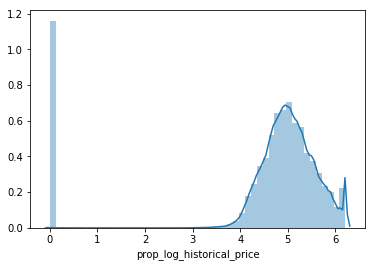

In [9]:
sns.distplot(data['prop_log_historical_price']);

### Boxplot

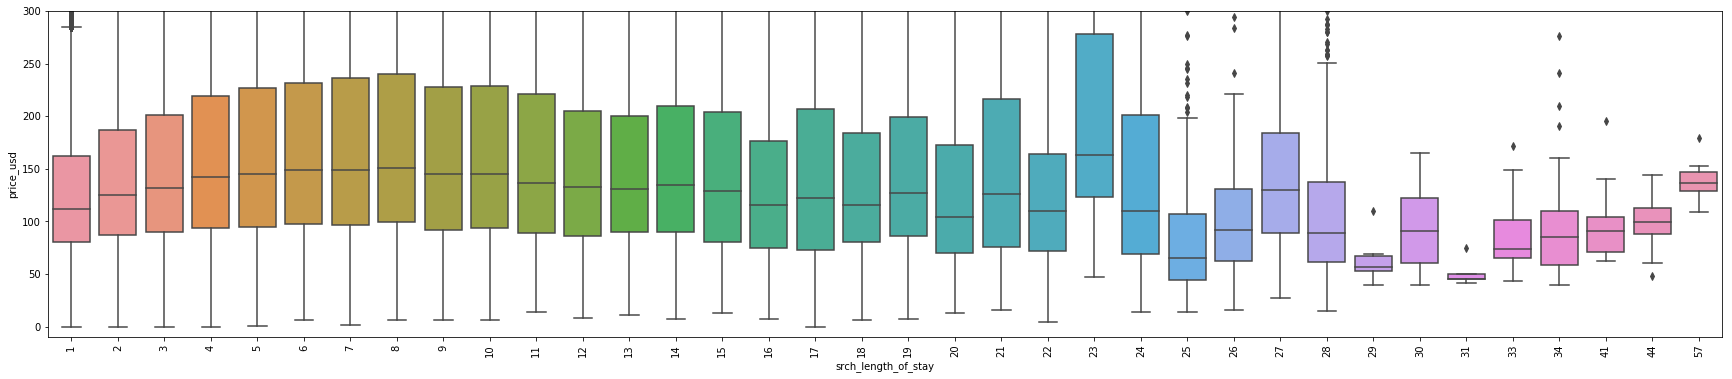

In [10]:
var = 'srch_length_of_stay'
d = pd.concat([data['price_usd'], data[var]], axis=1)
f, ax = plt.subplots(figsize=(30, 6))
fig = sns.boxplot(x=var, y="price_usd", data=d)
fig.axis(ymin=-10, ymax=300);
plt.xticks(rotation=90);

### Correlations of features

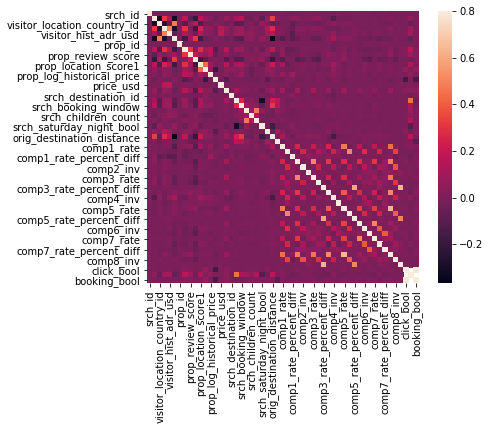

In [11]:
corrmat = data.corr()
f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(corrmat, vmax=.8, square=True);

In [12]:
least_missing_cols = missing_data_table.T.columns[-10:]

### Scatterplots

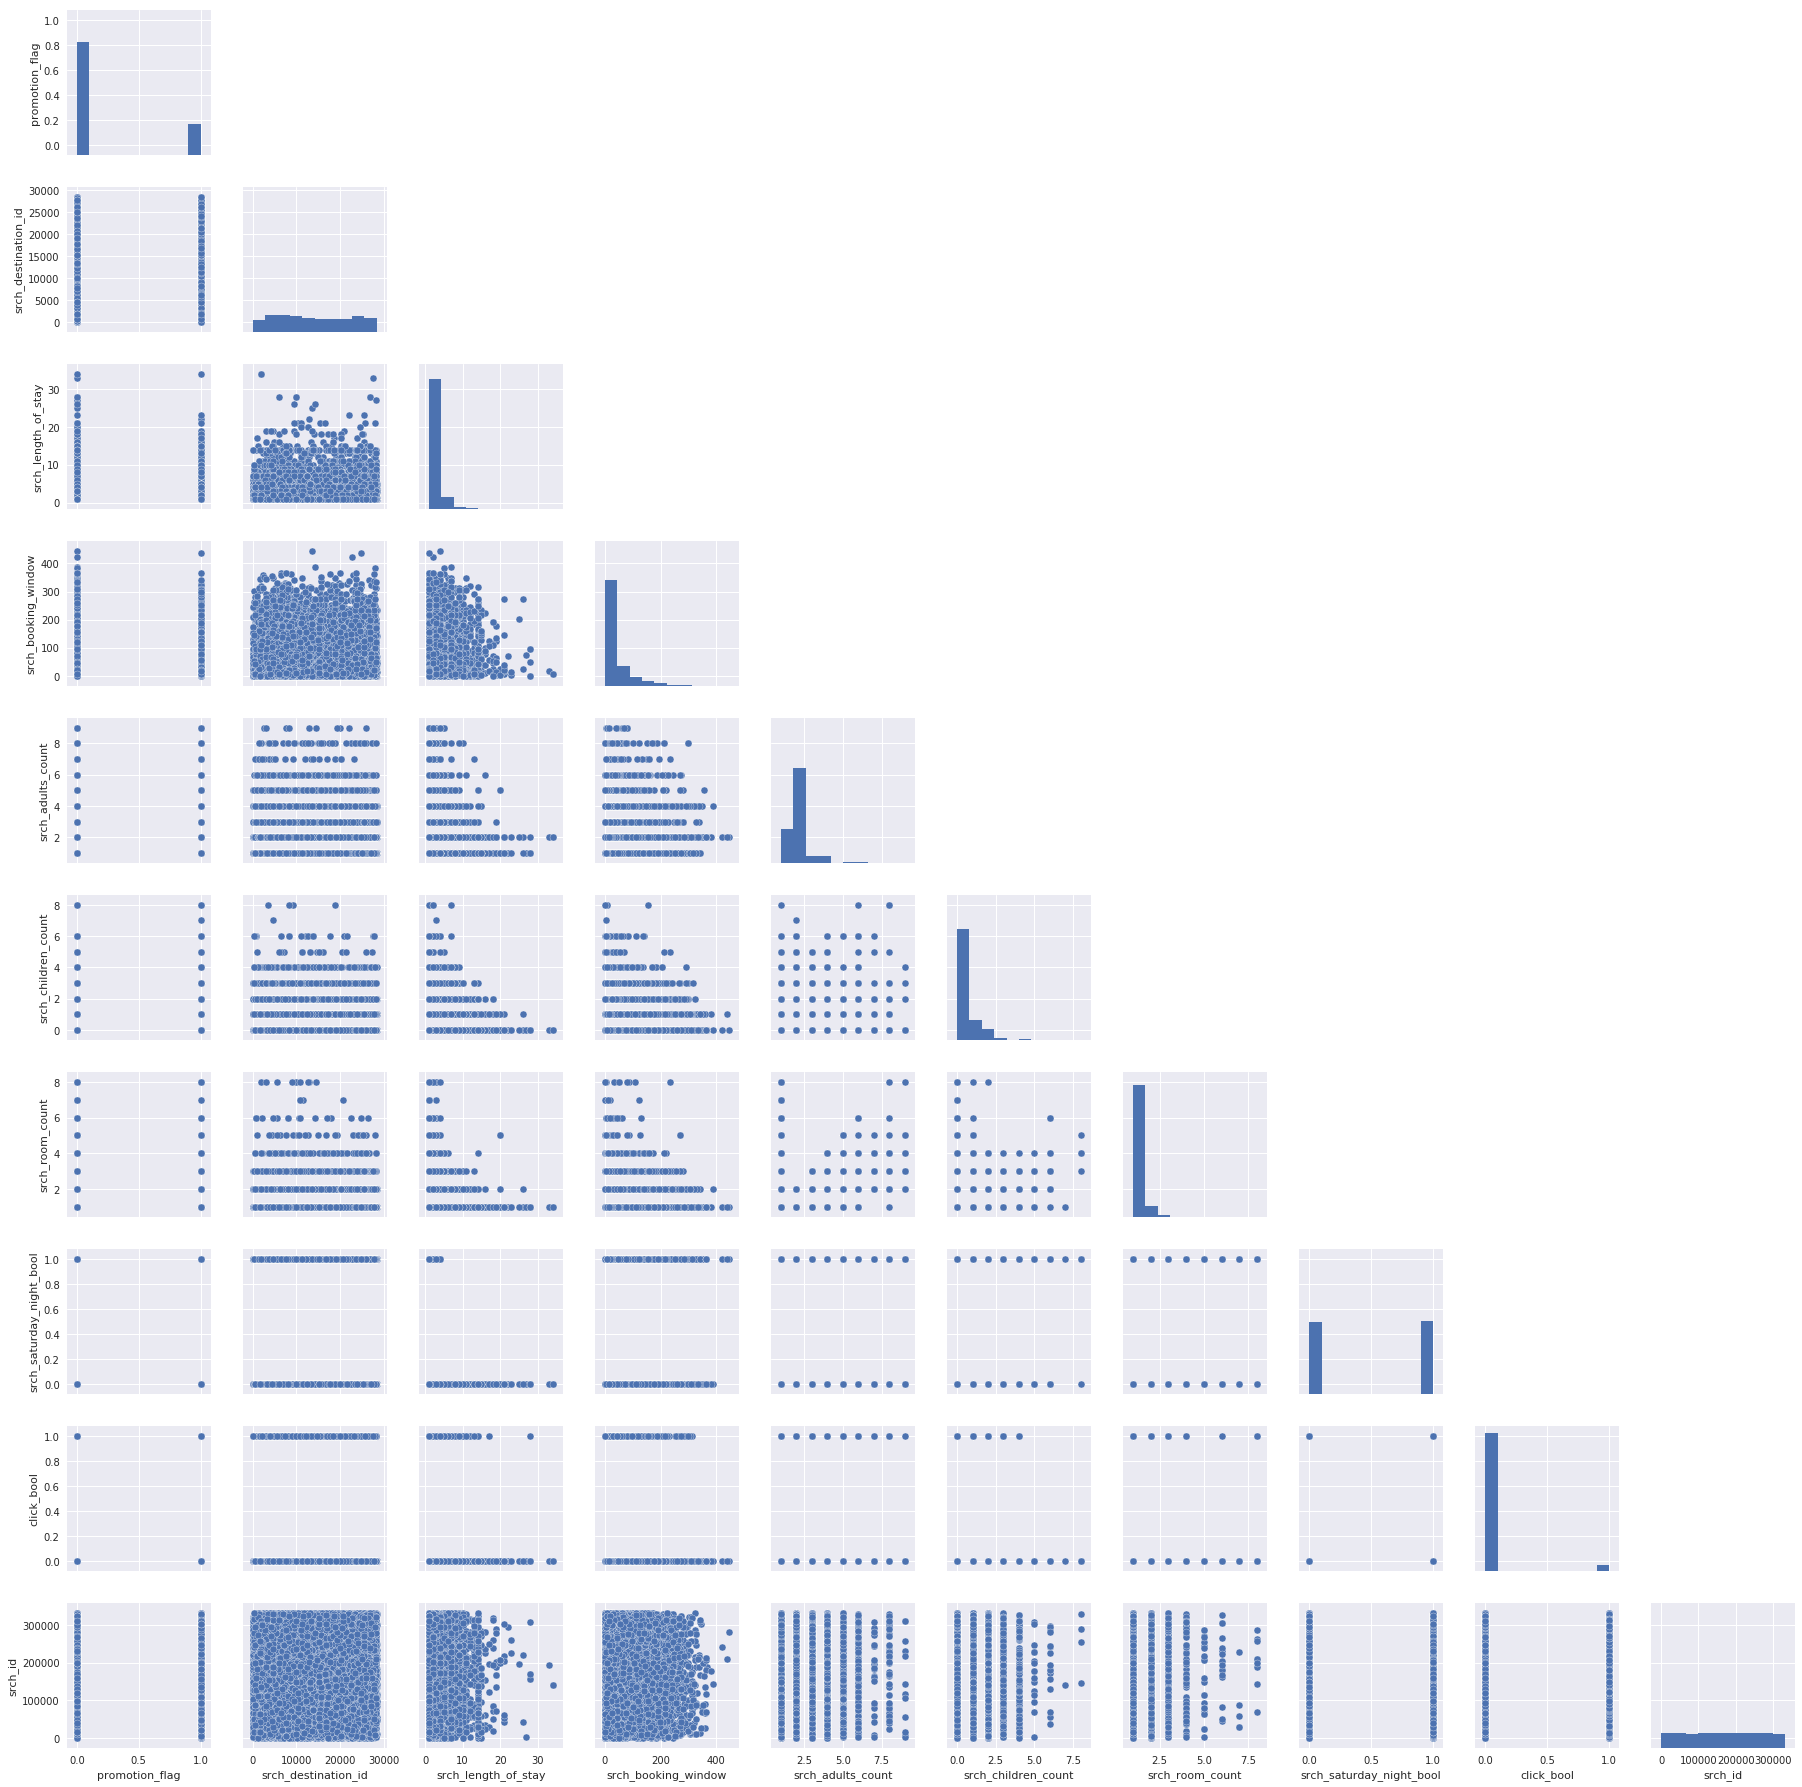

In [66]:
sns.set()
d = data[least_missing_cols].sample(n=30000, random_state=1)
g = sns.pairplot(d)
for i, j in zip(*np.triu_indices_from(g.axes, 1)):
    g.axes[i, j].set_visible(False)
plt.show();

### Histogram and normal probability plot

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


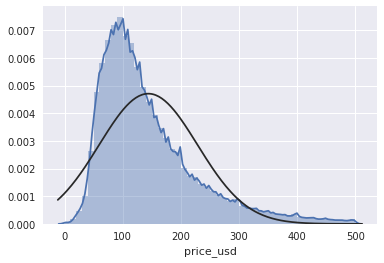

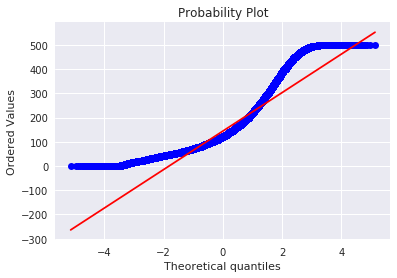

In [24]:
sns.distplot(data['price_usd'].loc[data['price_usd'] < 500], fit=norm);
fig = plt.figure()
res = stats.probplot(data['price_usd'].loc[data['price_usd'] < 500], plot=plt)

In [32]:
data['price_usd'] = data['price_usd'].apply(lambda x: np.log(x))

In [33]:
data_nona = data.fillna(method='ffill')

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


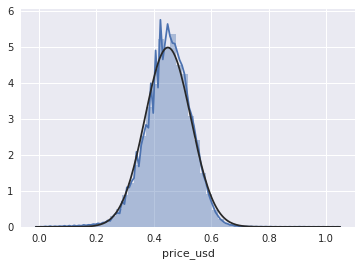

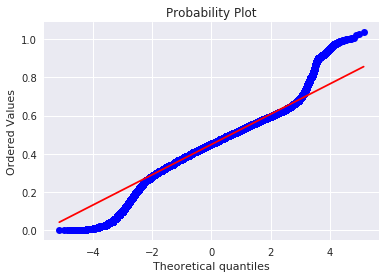

In [39]:
#histogram and normal probability plot
sns.distplot(data_nona['price_usd'].loc[data_nona['price_usd'] > 0], fit=norm);
plt.figure()
res = stats.probplot(data_nona['price_usd'].loc[data_nona['price_usd'] > 0], plot=plt)


### Count plots

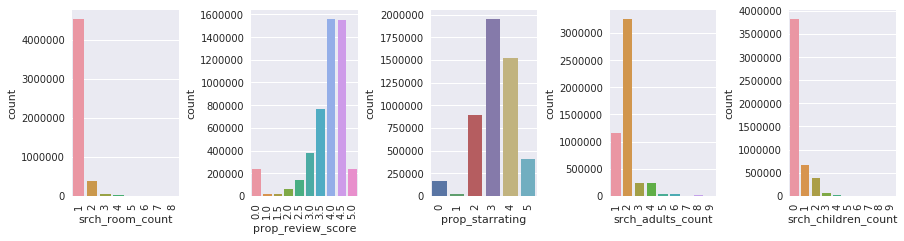

In [65]:
columns_showall = ['srch_room_count', 'prop_review_score', 'prop_starrating', 'srch_adults_count', 'srch_children_count' ]


(fig, subplots) = plt.subplots(nrows=1, ncols=len(columns_showall),figsize=(12, 3))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plt.tight_layout(pad=0.4, w_pad=3.5, h_pad=21.0)


for i, col in enumerate(columns_showall):
    plt.setp(subplots[i].xaxis.get_majorticklabels(), rotation=90 )
    d = data[[col]]
    fig = sns.countplot(x=col, data=d, ax=subplots[i])
    
    
# # show ordered
# var = 'prop_review_score'
# d = data[[var]]
# fig = sns.countplot(x=var, data=d, order=d.prop_review_score.value_counts().index, ax=subplots[0])
# var = 'srch_room_count'
# d = data[[var]]
# fig = sns.countplot(x=var, data=d, order=d.srch_room_count.value_counts().index, ax=subplots[1])
# var = 'srch_adults_count'
# d = data[[var]]
# fig = sns.countplot(x=var, data=d, order=d.srch_adults_count.value_counts().index, ax=subplots[2])